### Aim: practice using RNNs

# LTSM approach

In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from keras.backend import tensorflow_backend as tb
from sklearn.model_selection import train_test_split
import datetime as dt
import IPython
import keras as k
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import tensorflow as tf
plt.style.use('fivethirtyeight')
print("Session setup successful")

Using TensorFlow backend.


Session setup successful


In [3]:
# # Uncomment the below code in order to allow gradual memory alloc
# # Set up resizable memory: this code will allow gradual memory allocation instead of
# #     trying to allocate something like 4GB at once on your video card
random_seed = 1 # Random seed included for reproducability/consistency reasons when learning. Change as necessary.
np.random.seed(random_seed)
if tb._SESSION is None:
    if not os.environ.get('OMP_NUM_THREADS'):
        config = tf.ConfigProto(allow_soft_placement=True)
    else:
        num_thread = int(os.environ.get('OMP_NUM_THREADS'))
        config = tf.ConfigProto(intra_op_parallelism_threads=num_thread, allow_soft_placement=True)
    config.gpu_options.allow_growth=True
    _SESSION = tf.Session(config=config)
session = _SESSION
print('Gradual memory alloc setup successful!')

Gradual memory alloc setup successful!


In [5]:
# Some functions to help out with
def plot_predictions(test,predicted,stock='IBM') -> None:
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(stock + ' Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted) -> None:
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [6]:
stock_data_path = '../data/stock-time-series-20050101-to-20171231/'
os.listdir(stock_data_path)[:5]

['AABA_2006-01-01_to_2018-01-01.csv',
 'AAPL_2006-01-01_to_2018-01-01.csv',
 'all_stocks_2006-01-01_to_2018-01-01.csv',
 'all_stocks_2017-01-01_to_2018-01-01.csv',
 'AMZN_2006-01-01_to_2018-01-01.csv']

In [33]:
# First, we get the data
dataset = pd.read_csv(stock_data_path + 'IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
print("Number of entries in dataframe:", len(dataset))
dataset.head(3)

Number of entries in dataframe: 3020


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM


In [34]:
# Siddarth: Checking for missing values (K: ??? This doesn't do any null checking AFAIK!)
training_set = dataset[:'2016'].iloc[:,3:4].values
test_set = dataset['2017':].iloc[:,3:4].values

In [35]:
print("Num. of elements in training_set:", len(training_set))
print("Num. of elements in test_set:", len(test_set))
# tr = training_set
# ts = test_set
# len(ts)

Num. of elements in training_set: 2769
Num. of elements in test_set: 251


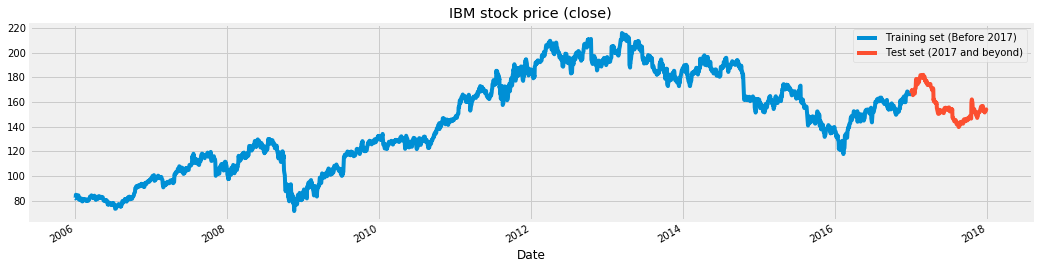

In [36]:
# Siddarth: "We have chosen 'High' attribute for prices. Let's see what it looks like"
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price (close)')
plt.show()

In [37]:
# Scaling the training set
sc = MinMaxScaler()  # TODO: check that feature_range default is indeed 0,1
training_set_scaled = sc.fit_transform(training_set)

In [38]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
num_prev_elems = 60
X_train = []
y_train = []
for i in range(num_prev_elems, len(training_set)):  # training set is 2759 elems long
    X_train.append(training_set_scaled[i-num_prev_elems:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [39]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # <

In [40]:
# Build LTSM model
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(units=40, return_sequences=True))
regressor.add(LSTM(units=30, return_sequences=True))
regressor.add(LSTM(units=20))
regressor.add(Dense(units=1))
# model variables
ltsm_batch_size = 48
ltsm_epochs = 5
# Some other optimizers include: RMSprop,Adagrad,Adadelta,Adam
ltsm_optimizer = k.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) # Siddarth
# ltsm_optimizer = k.optimizers.Adam()
regressor.compile(optimizer=ltsm_optimizer, loss='mean_squared_error')  # TODO: figure out other loss functions. Hinge?
ltsm_runtime_name = 'LTSM_504030_ADAM' \
+ '_BS' + str(ltsm_batch_size) \
+ '_epochs' + str(ltsm_epochs) \
+ '_StopEarly' \
+ '_' + str(dt.datetime.now()).replace(":","H",1).replace(":","M",1)
# Declare callbacks  # Some metrics to MONITER include 'loss' and 'val_loss'
stopearly = k.callbacks.EarlyStopping(monitor='loss', min_delta=0.0009, patience=1, verbose=1,
                                      mode='auto', baseline=None, restore_best_weights=False)
tensorboard_ltsm = k.callbacks.TensorBoard(log_dir='../tensorboard/' + ltsm_runtime_name,
                                           histogram_freq=0,batch_size=ltsm_batch_size, write_graph=True, write_images=True)

In [ ]:
# # # Visualize model (OK to comment-out)
# k.utils.plot_model(regressor, to_file='../visualizations/' + ltsm_runtime_name +'.png', show_shapes=True)
# IPython.display.Image('../visualizations/' + ltsm_runtime_name + '.png')

In [27]:
# Train model
history = regressor.fit(X_train, y_train, epochs=ltsm_epochs, batch_size=ltsm_batch_size,  # shuffle=True,
                        verbose=1, callbacks=[stopearly, tensorboard_ltsm])

Epoch 1/5
2709/2709 [==============================] - 25s 9ms/step - loss: 0.0221
Epoch 2/5
2709/2709 [==============================] - 23s 8ms/step - loss: 0.0062
Epoch 3/5
2709/2709 [==============================] - 22s 8ms/step - loss: 0.0046
Epoch 4/5
2709/2709 [==============================] - 22s 8ms/step - loss: 0.0043
Epoch 00004: early stopping


In [43]:
# Prep test set similar to train set
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless
# we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat(
    (dataset["Close"][:'2016'],
     dataset["Close"]['2017':]),axis=0)
print('len(datasettotal)', len(dataset_total))
print('len(test_set)', len(test_set))
print()
# Get inputs as _
inputs = dataset_total[ len(dataset_total) - len(test_set) - num_prev_elems: ].values
print("Sample of inputs:", inputs[:5])
# Reshape inputs
inputs = inputs.reshape(-1,1)
print("Sample of inputs reshaped:", inputs[:5])
# Squishify inputs between 0 and 1
inputs  = sc.transform(inputs)
print("Samples of inputs transformed:", inputs[:5])

len(datasettotal) 3020
len(test_set) 251

Sample of inputs: [156.88 155.67 157.02 154.79 154.29]
Sample of inputs reshaped: [[156.88]
 [155.67]
 [157.02]
 [154.79]
 [154.29]]
Samples of inputs transformed: [[0.59100375]
 [0.58260447]
 [0.59197557]
 [0.5764959 ]
 [0.57302513]]


In [44]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(num_prev_elems, 311):  # How did this value of 311 get calculated?
    X_test.append(
        inputs[i - num_prev_elems:i, 0]
    )
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

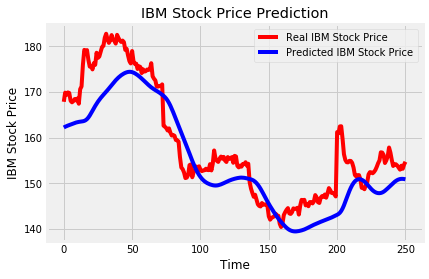

In [30]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [31]:
# Evaluating our model
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 6.199504647230537.


---

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

In [45]:
# The GRU architecture (original architecture has 20% dropout b/w layers)
regressorGRU = Sequential()
regressorGRU.add(GRU(units=45, return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))  # TODO: he specifies tanh function, but whats the default? other options are..?
regressorGRU.add(GRU(units=30, return_sequences=True,  # TODO: why input shape thru all levels? necessary?
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(GRU(units=20, return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(GRU(units=10, activation='tanh'))
regressorGRU.add(Dense(units=1))
# Model variables
gru_batch_size = 32 # keras.losses.hinge(y_true, y_pred)

gru_epochs = 6
# model_optimizer = SGD(lr=0.005, decay=1e-7, momentum=0.95, nesterov=False)  # Default
# gru_optimizer = k.optimizers.Adadelta()  # First run of Adadelta was S L O W compared to SGD. Terrible error on a 3 epoch run. Not great.
# gru_optimizer = k.optimizers.Adam() # Great first run. Small error, small lag behind actual data
# gru_optimizer = k.optimizers.Adagrad()  # OK. Good adherence to small changes, but error larger than liked.
gru_optimizer = k.optimizers.RMSprop() # Great! great adherence, low error. a good contender. 
# gru_optimizer = SGD()  # Standard out. Error normal, not bad but not great. 

regressorGRU.compile(optimizer=gru_optimizer, loss=k.losses.mean_squared_error)
# Callbacks
stopearly = k.callbacks.EarlyStopping(monitor='loss', min_delta=0.0009, patience=1, verbose=1,
                                      mode='auto', baseline=None, restore_best_weights=False)
gru_runtime_name = 'GRU_45302010_RMSPROP' \
+ '_BS' + str(gru_batch_size) \
+ '_epochs' + str(gru_epochs) \
+ '_StopEarly' \
+ '_' + str(dt.datetime.now()).replace(":","H",1).replace(":","M",1)
tensorboard_gru = k.callbacks.TensorBoard(log_dir='../tensorboard/' + gru_runtime_name, histogram_freq=0, batch_size=gru_batch_size, write_graph=True, write_images=True)

In [46]:
# # Visualize model
# k.utils.plot_model(regressorGRU, to_file='../visualizations/' + gru_runtime_name +'.png', show_shapes=True)
# IPython.display.Image('../visualizations/' + gru_runtime_name +'.png')

In [47]:
# Train model
history = regressorGRU.fit(X_train, y_train, epochs=gru_epochs, batch_size=gru_batch_size,  # shuffle=True,
                        verbose=1, callbacks=[stopearly, tensorboard_gru])

Epoch 1/6
2709/2709 [==============================] - 29s 11ms/step - loss: 0.0091
Epoch 2/6
2709/2709 [==============================] - 27s 10ms/step - loss: 0.0024
Epoch 3/6
2709/2709 [==============================] - 29s 11ms/step - loss: 0.0020
Epoch 00003: early stopping


In [48]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(num_prev_elems, 311):
    X_test.append(inputs[i - num_prev_elems:i, 0])
# print("X_test after appendsc:", X_test)
X_test = np.array(X_test)
# TODO: below: decode reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

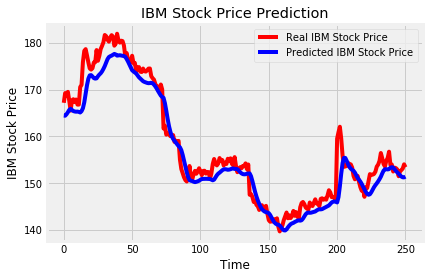

In [54]:
# Visualizing the results for GRU
plot_predictions(test_set, GRU_predicted_stock_price)

In [55]:
# Evaluating GRU
return_rmse(test_set, GRU_predicted_stock_price)

The root mean squared error is 3.1017110191068307.


---
## Sequence Generation (Siddarth)
Here, I will generate a sequence using just initial (60) values instead of using last (60) values for every new prediction. **Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation.** The above models make use of test set so it is using last (60) true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set. A GRU model is used for predictions. 

In [57]:
len(training_set)

2769

In [51]:
# Preparing sequence data
initial_sequence = X_train[2708,:]  # TODO: how did this value of 2708 get generated?
sequence = []
for i in range(251):  # TODO: how did this value of 251 get generated?
    new_prediction = regressorGRU.predict(
        initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1)
    )
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))  # What does the array look like before reshape?

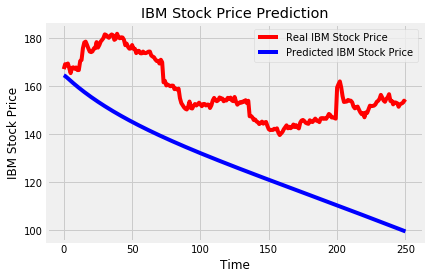

In [52]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [53]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 31.84784641984876.


So, GRU works better than LSTM in this case. Bidirectional LSTM is also a good way so make the model stronger. But this may vary for different data sets. **Applying both LSTM and GRU together gave even better results.** 